# Imports

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, roc_auc_score

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Initialise GPU

In [2]:
# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Data Loading and Pre-processing

In [3]:
# Class for pre-processing the data
class MIMICDataProcessor:
    def __init__(self, file_path, batch_size=64):
        self.file_path = file_path
        self.batch_size = batch_size
        self.scaler = StandardScaler()

        # Load and preprocess the data
        self.df = pd.read_csv(file_path)
        # Replace all missing values with 0
        self.df.fillna(0, inplace=True)

        # Features
        self.X = self.df[['aniongap_max', 'albumin_max', 'albumin_min', 'rsp_pao2fio2_vent_min', 'rsp_pao2fio2_novent_min',
                          'cgn_platelet_min', 'lvr_bilirubin_max', 'cdv_mbp_min', 'cdv_rate_dopamine', 'cdv_rate_dobutamine',
                          'cdv_rate_epinephrine', 'cdv_rate_norepinephrine', 'gcs_min', 'rfl_urineoutput', 'rfl_creatinine_max']]

        # Concepts
        self.C = self.df[['rsp_fail_moderate', 'rsp_fail_severe', 'cgn_fail_moderate', 'cgn_fail_severe', 'lvr_fail_moderate',
                          'lvr_fail_severe', 'cdv_fail_moderate', 'cdv_fail_severe', 'gcs_fail_moderate', 'gcs_fail_severe',
                          'rfl_fail_moderate', 'rfl_fail_severe', 'SSH', 'ARD', 'HES', 'COD', 'MOD', 'CRF', 'LCF',
                          'flag_high_aniongap', 'flag_low_albumin', 'flag_high_albumin', 'flag_high_bilirubin']]

        # Label
        self.Y = self.df['mortality_year']

        # Convert to tensors
        self.X_tensor = torch.tensor(self.X.values, dtype=torch.float32)
        self.C_tensor = torch.tensor(self.C.values, dtype=torch.float32)
        self.Y_tensor = torch.tensor(self.Y.values, dtype=torch.float32)

        # Normalize the features
        self.X_scaled = self.scaler.fit_transform(self.X)
        self.X_tensor_scaled = torch.tensor(self.X_scaled, dtype=torch.float32)

    def get_features(self):
        return self.X.columns.tolist()

    def get_concepts(self):
        return self.C.columns.tolist()

    def get_labels(self):
        return self.Y.columns.tolist()

    # Dataset class needed to provide the __getitem__ method for DataLoader
    class MIMICDataset(Dataset):
        def __init__(self, x, c, y):
            self.x = x
            self.c = c
            self.y = y

        def __len__(self):
            return len(self.y)

        def __getitem__(self, idx):
            return self.x[idx], self.c[idx], self.y[idx]

    def create_dataloaders(self):
        # Split the data into temporary (80%) and test (20%) sets
        X_temp, X_test, C_temp, C_test, Y_temp, Y_test = train_test_split(
            self.X_tensor_scaled, self.C_tensor, self.Y_tensor, test_size=0.20, random_state=42)

        # Further split the temporary data into training (75% of temporary) and validation (25% of temporary) sets
        X_train, X_val, C_train, C_val, Y_train, Y_val = train_test_split(
            X_temp, C_temp, Y_temp, test_size=0.25, random_state=42)

        train_dataset = self.MIMICDataset(X_train, C_train, Y_train)
        val_dataset = self.MIMICDataset(X_val, C_val, Y_val)
        test_dataset = self.MIMICDataset(X_test, C_test, Y_test)

        train_loader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=self.batch_size, shuffle=False)
        test_loader = DataLoader(test_dataset, batch_size=self.batch_size, shuffle=False)

        return train_loader, val_loader, test_loader

# Model

In [4]:
class MultiLabelNN(nn.Module):
    def __init__(self, num_features, num_labels):
        super(MultiLabelNN, self).__init__()
        self.layer1 = nn.Linear(num_features, 64)
        self.layer2 = nn.Linear(64, 128)
        self.output_layer = nn.Linear(128, num_labels)

    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        x = torch.sigmoid(self.output_layer(x))  # Sigmoid activation to output probabilities for each label
        return x

# Training

Look at the Step 5 from this [basic code](https://colab.research.google.com/drive/1LqE89tPVt6h1wa7lerLgF4GNvRw9QFDw?usp=sharing) for reference.

In [5]:
def train(x_size, c_size, y_size, x_to_c_learning_rate, c_to_y_learning_rate, epochs, train_loader, val_loader):
    torch.manual_seed(25)

    x_to_c = MultiLabelNN(num_features=x_size, num_labels=c_size).to(device)  # concept predictor
    c_to_y = MultiLabelNN(num_features=c_size, num_labels=y_size).to(device)  # label predictor

    criterion = nn.BCELoss()  # Binary Cross-Entropy Loss for classification
    x_to_c_optimizer = torch.optim.Adam(x_to_c.parameters(), lr=x_to_c_learning_rate)
    c_to_y_optimizer = torch.optim.Adam(c_to_y.parameters(), lr=c_to_y_learning_rate)

    x_to_c_scheduler = StepLR(x_to_c_optimizer, step_size=10, gamma=0.1)
    c_to_y_scheduler = StepLR(c_to_y_optimizer, step_size=10, gamma=0.1)

    epochs_count = []
    x_to_c_loss_values, c_to_y_loss_values = [], []
    x_to_c_predictions, c_to_y_predictions = [], []
    x_to_c_val_loss_values, c_to_y_val_loss_values = [], []
    x_to_c_val_predictions, c_to_y_val_predictions = [], []
    ground_truth_val_c, ground_truth_val_y = [], []

    best_val_loss = float('inf')
    patience, trials = 10, 0

    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")  # Print current epoch
        epochs_count.append(epoch)

        # Training Loop
        x_to_c.train()
        c_to_y.train()

        running_x_to_c_loss, running_c_to_y_loss = 0.0, 0.0
        total_samples = 0

        for i, batch in enumerate(train_loader):
            x, c, y = batch
            x, c, y = x.to(device), c.to(device), y.to(device)

            # Forward pass through x_to_c
            x_to_c_optimizer.zero_grad()
            x = x.to(x_to_c.layer1.weight.dtype)  # ensure data type of input tensor x matches data type of weights of the first linear layer
            predicted_c = x_to_c(x)
            x_to_c_predictions.append(predicted_c.detach().cpu().numpy())
            c_loss = criterion(predicted_c, c.float())

            # Backward pass through x_to_c
            c_loss.backward()
            x_to_c_optimizer.step()

            # Forward pass through c_to_y
            c_to_y_optimizer.zero_grad()
            predicted_c_detached = predicted_c.detach()  # Detach the predicted_c tensor
            predicted_y = c_to_y(predicted_c_detached)
            c_to_y_predictions.append(predicted_y.detach().cpu().numpy())
            y_loss = criterion(predicted_y, y.unsqueeze(1).float())

            # Backward pass through c_to_y
            y_loss.backward()
            c_to_y_optimizer.step()

            # Accumulate loss values
            running_x_to_c_loss += c_loss.item()
            running_c_to_y_loss += y_loss.item()

            total_samples += len(y)

        x_to_c_loss_values.append(running_x_to_c_loss / len(train_loader))
        c_to_y_loss_values.append(running_c_to_y_loss / len(train_loader))

        # Step the schedulers
        x_to_c_scheduler.step()
        c_to_y_scheduler.step()

        # valing Loop
        x_to_c.eval()
        c_to_y.eval()

        running_x_to_c_val_loss, running_c_to_y_val_loss = 0.0, 0.0
        total_val_samples = 0

        with torch.no_grad():
            for x, c, y in val_loader:
                x, c, y = x.to(device), c.to(device), y.to(device)

                ground_truth_val_c.append(c.cpu())
                ground_truth_val_y.append(y.cpu())

                # Forward pass through x_to_c
                predicted_c = x_to_c(x.to(dtype=x_to_c.layer1.weight.dtype))
                x_to_c_val_predictions.append(predicted_c.detach().cpu().numpy())
                c_loss = criterion(predicted_c, c.float())

                # Accumulate x_to_c loss for valing
                running_x_to_c_val_loss += c_loss.item()

                # Forward pass through c_to_y
                predicted_c_detached = predicted_c.detach()  # Detach the predicted_c tensor
                predicted_y = c_to_y(predicted_c_detached)
                c_to_y_val_predictions.append(predicted_y.detach().cpu().numpy())
                y_loss = criterion(predicted_y, y.unsqueeze(1).float())

                # Accumulate c_to_y loss for valing
                running_c_to_y_val_loss += y_loss.item()
                total_val_samples += len(y)

        x_to_c_val_loss_values.append(running_x_to_c_val_loss / len(val_loader))
        c_to_y_val_loss_values.append(running_c_to_y_val_loss / len(val_loader))

        # Early stopping
        if running_c_to_y_val_loss / len(val_loader) < best_val_loss:
            best_val_loss = running_c_to_y_val_loss / len(val_loader)
            trials = 0
        else:
            trials += 1
            if trials >= patience:
                print("Early stopping")
                break

    return (x_to_c, c_to_y, epochs_count, x_to_c_loss_values, c_to_y_loss_values, x_to_c_predictions, c_to_y_predictions, x_to_c_val_loss_values, c_to_y_val_loss_values, x_to_c_val_predictions, c_to_y_val_predictions, ground_truth_val_c, ground_truth_val_y)

In [6]:
# Specify Parameters
x_size = 15
c_size = 23
y_size = 1
x_to_c_learning_rate = 0.01
c_to_y_learning_rate = 0.01
lamda = 0.3
epochs = 60

# Load Data
file_path = '/content/cohorta_trial1_data.csv'
data_processor = MIMICDataProcessor(file_path, batch_size=64)
train_loader, test_loader, val_loader = data_processor.create_dataloaders()

x_to_c, c_to_y, epochs_count, x_to_c_loss_values, c_to_y_loss_values, x_to_c_predictions, c_to_y_predictions, x_to_c_val_loss_values, c_to_y_val_loss_values, x_to_c_val_predictions, c_to_y_val_predictions, ground_truth_val_c, ground_truth_val_y = train(x_size, c_size, y_size, x_to_c_learning_rate, c_to_y_learning_rate, epochs, train_loader, val_loader)

Epoch 1/60
Epoch 2/60
Epoch 3/60
Epoch 4/60
Epoch 5/60
Epoch 6/60
Epoch 7/60
Epoch 8/60
Epoch 9/60
Epoch 10/60
Epoch 11/60
Epoch 12/60
Epoch 13/60
Epoch 14/60
Epoch 15/60
Early stopping


# Plotting Loss

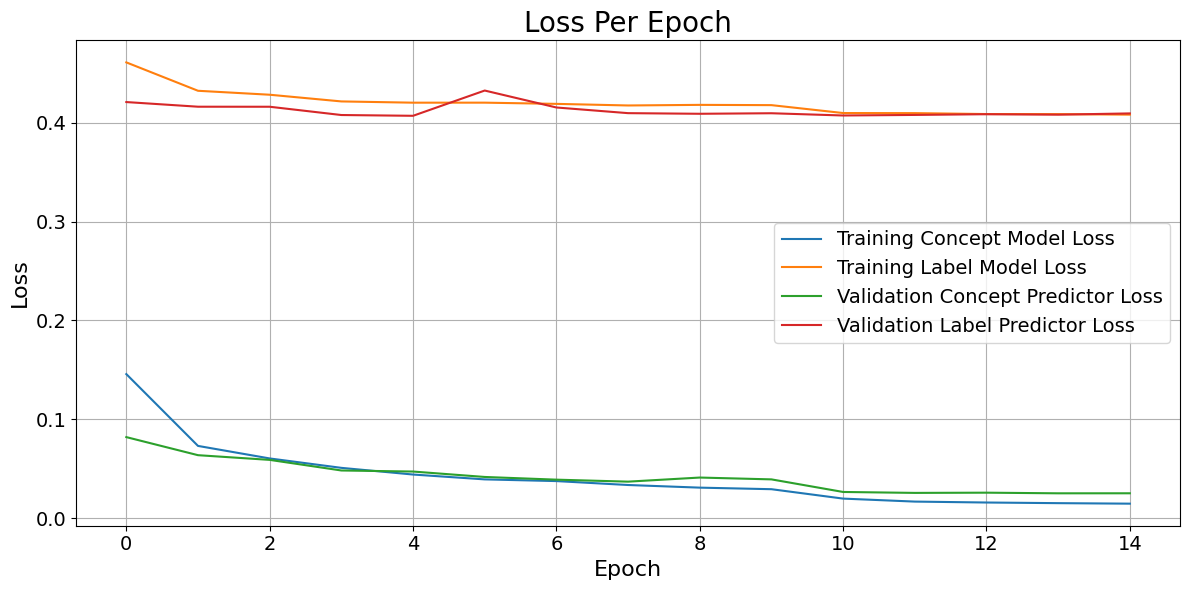

In [7]:
plt.figure(figsize=(12, 6))
plt.plot(epochs_count, x_to_c_loss_values, label='Training Concept Model Loss')
plt.plot(epochs_count, c_to_y_loss_values, label='Training Label Model Loss')
plt.plot(epochs_count, x_to_c_val_loss_values, label='Validation Concept Predictor Loss')
plt.plot(epochs_count, c_to_y_val_loss_values, label='Validation Label Predictor Loss')

plt.title('Loss Per Epoch', fontsize=20)
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(fontsize=14)
plt.grid(True)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.tight_layout()
plt.savefig('mort-seq-es.png')
plt.show()

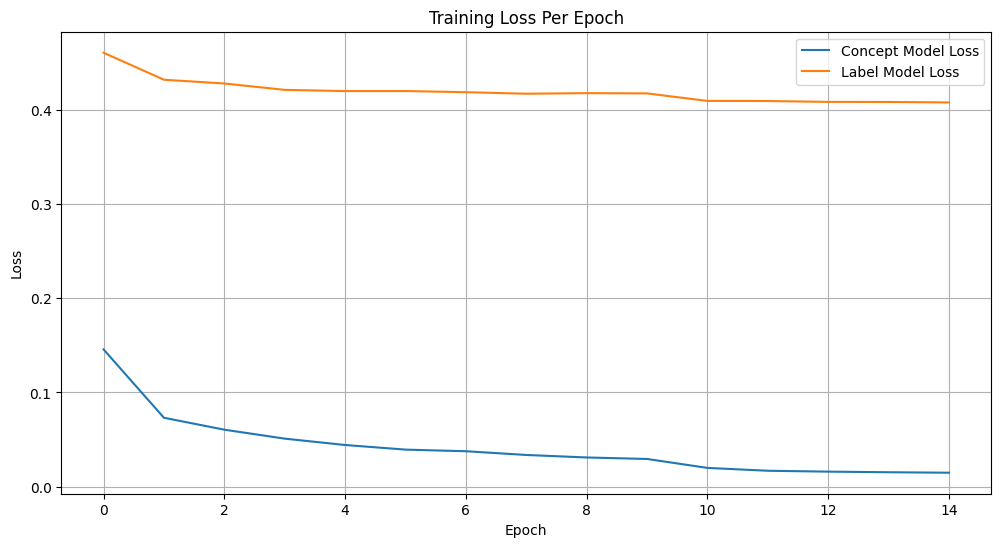

In [8]:
# Training loss
plt.figure(figsize=(12, 6))
plt.plot(epochs_count, x_to_c_loss_values, label='Concept Model Loss')
plt.plot(epochs_count, c_to_y_loss_values, label='Label Model Loss')
plt.title('Training Loss Per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

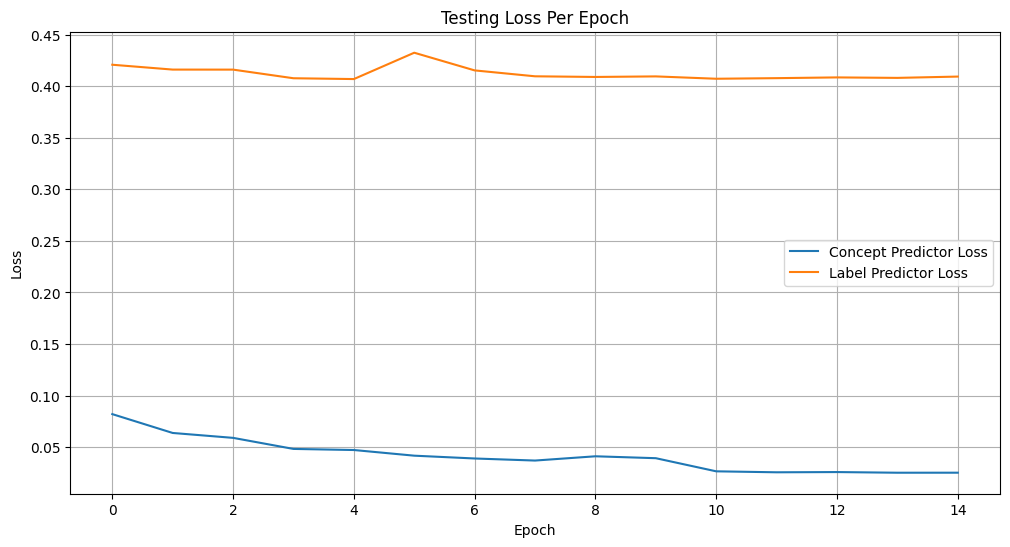

In [9]:
# Testing loss
plt.figure(figsize=(12, 6))
plt.plot(epochs_count, x_to_c_val_loss_values, label='Concept Predictor Loss')
plt.plot(epochs_count, c_to_y_val_loss_values, label='Label Predictor Loss')
plt.title('Testing Loss Per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Validation Evaluation

In [10]:
# Concept Predictor Evaluation
def evaluate_concept_predictor(ground_truth_c, x_to_c_predictions, concept_labels):
    results = []
    precisions = []
    recalls = []
    f1_scores = []
    aucs = []
    accuracies = []

    for i, label in enumerate(concept_labels):
        true_values = np.concatenate([c[:, i].numpy() for c in ground_truth_c])
        predicted_values = np.concatenate([c[:, i] for c in x_to_c_predictions])

        predicted_classes = (predicted_values > 0.5).astype(int)  # Convert probabilities to binary classes

        precision = precision_score(true_values, predicted_classes, zero_division=0)
        recall = recall_score(true_values, predicted_classes, zero_division=0)
        f1 = f1_score(true_values, predicted_classes, zero_division=0)
        auc = roc_auc_score(true_values, predicted_classes)
        accuracy = accuracy_score(true_values, predicted_classes)

        precisions.append(precision)
        recalls.append(recall)
        f1_scores.append(f1)
        aucs.append(auc)
        accuracies.append(accuracy)

        results.append({
            "Label": label,
            "Precision": precision,
            "Recall": recall,
            "F1 Score": f1,
            "AUC": auc,
            "Accuracy": accuracy
        })

    # Calculate the average values for each metric
    avg_precision = np.mean(precisions)
    avg_recall = np.mean(recalls)
    avg_f1 = np.mean(f1_scores)
    avg_auc = np.mean(aucs)
    avg_accuracy = np.mean(accuracies)

    # Append the average values to the results
    results.append({
        "Label": "Average",
        "Precision": avg_precision,
        "Recall": avg_recall,
        "F1 Score": avg_f1,
        "AUC": avg_auc,
        "Accuracy": avg_accuracy
    })

    return pd.DataFrame(results)

In [11]:
# Get concept labels from the data processor
concept_labels = data_processor.get_concepts()

# Evaluation
concept_predictor_results = evaluate_concept_predictor(ground_truth_val_c, x_to_c_val_predictions, concept_labels)
print("Validation Concept Predictor Results:")
print(concept_predictor_results)

Validation Concept Predictor Results:
                  Label  Precision    Recall  F1 Score       AUC  Accuracy
0     rsp_fail_moderate   0.884071  0.874531  0.879275  0.924530  0.956353
1       rsp_fail_severe   0.735360  0.512661  0.604141  0.753265  0.978393
2     cgn_fail_moderate   0.947382  0.955336  0.951342  0.964684  0.967888
3       cgn_fail_severe   0.304933  0.206061  0.245931  0.601735  0.993069
4     lvr_fail_moderate   0.924295  0.924456  0.924376  0.958231  0.985556
5       lvr_fail_severe   0.905433  0.857143  0.880626  0.928177  0.997972
6     cdv_fail_moderate   0.985481  0.980363  0.982915  0.973265  0.976116
7       cdv_fail_severe   0.950804  0.914583  0.932342  0.955892  0.992587
8     gcs_fail_moderate   0.990727  0.986277  0.988497  0.990833  0.992354
9       gcs_fail_severe   0.876008  0.851961  0.863817  0.923864  0.990892
10    rfl_fail_moderate   0.904027  0.860250  0.881595  0.912391  0.935361
11      rfl_fail_severe   0.761943  0.651020  0.702128  0.8202

In [12]:
# Label Predictor Evaluation
def evaluate_label_predictor(ground_truth_y, c_to_y_predictions):
    # Ensure all elements are tensors
    ground_truth_y = [torch.tensor(gy) if not isinstance(gy, torch.Tensor) else gy for gy in ground_truth_y]
    c_to_y_predictions = [torch.tensor(py) if not isinstance(py, torch.Tensor) else py for py in c_to_y_predictions]

    true_values = torch.cat(ground_truth_y).numpy()
    predicted_values = torch.cat(c_to_y_predictions).squeeze().numpy()

    predicted_classes = (predicted_values > 0.5).astype(int)  # Convert probabilities to binary classes

    precision = precision_score(true_values, predicted_classes)
    recall = recall_score(true_values, predicted_classes)
    f1 = f1_score(true_values, predicted_classes)
    auc = roc_auc_score(true_values, predicted_classes)
    accuracy = accuracy_score(true_values, predicted_classes)

    results = {"Precision": precision,
        "Recall": recall,
        "F1 Score": f1,
        "AUC": auc,
        "Accuracy": accuracy}

    index = pd.Index(["Metrics"])
    return pd.DataFrame(results, index=index)

In [13]:
# Evaluation
print("Validation Label Predictor Results:")
label_predictor_results = evaluate_label_predictor(ground_truth_val_y, c_to_y_val_predictions)
print(label_predictor_results)

Validation Label Predictor Results:
         Precision    Recall  F1 Score       AUC  Accuracy
Metrics   0.764107  0.270931  0.400024  0.624834   0.83527


# Testing Evaluation

In [14]:
def test_model(x_to_c, c_to_y, test_loader):
    x_to_c.eval()  # Set the concept predictor model to evaluation mode
    c_to_y.eval()  # Set the label predictor model to evaluation mode
    criterion = nn.BCELoss()  # Binary Cross-Entropy Loss for classification

    running_x_to_c_test_loss, running_c_to_y_test_loss = 0.0, 0.0
    total_test_samples = 0
    ground_truth_test_c, ground_truth_test_y = [], []
    x_to_c_test_predictions, c_to_y_test_predictions = [], []

    with torch.no_grad():
        for x, c, y in test_loader:
            # GPU
            x, c, y = x.to(device), c.to(device), y.to(device)

            # Ground truth array
            ground_truth_test_c.append(c.cpu())
            ground_truth_test_y.append(y.cpu())

            # Forward pass through x_to_c
            x = x.to(x_to_c.layer1.weight.dtype)  # ensure data type of input tensor x matches data type of weights of the first linear layer
            predicted_c = x_to_c(x)
            x_to_c_test_predictions.append(predicted_c.detach().cpu().numpy())
            c_loss = criterion(predicted_c, c.float())

            # Accumulate x_to_c loss for testing
            running_x_to_c_test_loss += c_loss.item()

            # Forward pass through c_to_y
            predicted_c_detached = predicted_c.detach()  # Detach the predicted_c tensor
            predicted_y = c_to_y(predicted_c_detached)
            c_to_y_test_predictions.append(predicted_y.detach().cpu().numpy())
            y_loss = criterion(predicted_y, y.unsqueeze(1).float())

            # Accumulate c_to_y loss for testing
            running_c_to_y_test_loss += y_loss.item()
            total_test_samples += len(y)

    print(f'Test Concept Predictor Loss: {running_x_to_c_test_loss / len(test_loader):.4f}')
    print(f'Test Label Predictor Loss: {running_c_to_y_test_loss / len(test_loader):.4f}')

    return ground_truth_test_c, ground_truth_test_y, x_to_c_test_predictions, c_to_y_test_predictions

In [15]:
# Call the test function and print the results
ground_truth_test_c, ground_truth_test_y, x_to_c_test_predictions, c_to_y_test_predictions = test_model(x_to_c, c_to_y, test_loader)

Test Concept Predictor Loss: 0.0238
Test Label Predictor Loss: 0.4203


In [16]:
# Evaluate and print test results for the concept predictor
concept_test_results = evaluate_concept_predictor(ground_truth_test_c, x_to_c_test_predictions, concept_labels)
print("Test Concept Predictor Results:")
print(concept_test_results)

Test Concept Predictor Results:
                  Label  Precision    Recall  F1 Score       AUC  Accuracy
0     rsp_fail_moderate   0.928276  0.924451  0.926359  0.954306  0.973323
1       rsp_fail_severe   0.859649  0.777778  0.816667  0.886830  0.989030
2     cgn_fail_moderate   0.983994  0.976551  0.980258  0.984371  0.987036
3       cgn_fail_severe   0.473684  0.310345  0.375000  0.653917  0.992521
4     lvr_fail_moderate   0.968293  0.965937  0.967113  0.981163  0.993269
5       lvr_fail_severe   0.896552  0.962963  0.928571  0.981105  0.999003
6     cdv_fail_moderate   0.994178  0.991652  0.992913  0.989456  0.990277
7       cdv_fail_severe   0.957364  0.961089  0.959223  0.979080  0.994764
8     gcs_fail_moderate   0.995714  0.995004  0.995359  0.996352  0.996759
9       gcs_fail_severe   0.892086  0.898551  0.895307  0.947339  0.992770
10    rfl_fail_moderate   0.943810  0.932350  0.938045  0.954979  0.964597
11      rfl_fail_severe   0.843373  0.663507  0.742706  0.828333  0.

In [17]:
# Evaluate and print test results for the label predictor
label_test_results = evaluate_label_predictor(ground_truth_test_y, c_to_y_test_predictions)
print("Test Label Predictor Results:")
print(label_test_results)

Test Label Predictor Results:
         Precision    Recall  F1 Score       AUC  Accuracy
Metrics   0.744253  0.293318  0.420796  0.632433  0.822239


# Model Weights


In [20]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Function to get weights contribution from each feature to each concept
def get_feature_to_concept_weights(model, feature_names, concept_names):
    layer1_weights = model.layer1.weight.data.cpu().numpy()
    contributions = np.zeros((len(concept_names), len(feature_names)))

    for i, feature in enumerate(feature_names):
        for j, concept in enumerate(concept_names):
            contributions[j, i] = layer1_weights[j, i]

    return pd.DataFrame(contributions, index=concept_names, columns=feature_names)

# Function to get weights contribution from each concept to final label
def get_concept_to_label_weights(model, concept_names, label_names):
    output_weights = model.output_layer.weight.data.cpu().numpy()
    contributions = np.zeros((len(label_names), len(concept_names)))

    for i, concept in enumerate(concept_names):
        for j, label in enumerate(label_names):
            contributions[j, i] = output_weights[j, i]

    return pd.DataFrame(contributions, index=label_names, columns=concept_names)

# Get feature and concept names
feature_names = data_processor.get_features()
concept_names = data_processor.get_concepts()
label_names = ['mortality_year']

# Get weights contributions
feature_to_concept_contributions = get_feature_to_concept_weights(x_to_c, feature_names, concept_names)
concept_to_label_contributions = get_concept_to_label_weights(c_to_y, concept_names, label_names)

# Get weights contributions
feature_to_concept_contributions = get_feature_to_concept_weights(x_to_c, feature_names, concept_names)
concept_to_label_contributions = get_concept_to_label_weights(c_to_y, concept_names, label_names)

# Extract the weights for the label 'Mortality'
concept_to_label_weights = concept_to_label_contributions.loc[label_names[0]].values

# Reshape concept_to_label_weights for element-wise multiplication
concept_to_label_weights = concept_to_label_weights.reshape(-1, 1)

# Calculate the combined contributions by element-wise multiplication
combined_contributions = feature_to_concept_contributions.values * concept_to_label_weights

# Create a DataFrame for the combined contributions
combined_df = pd.DataFrame(combined_contributions, index=concept_names, columns=feature_names)

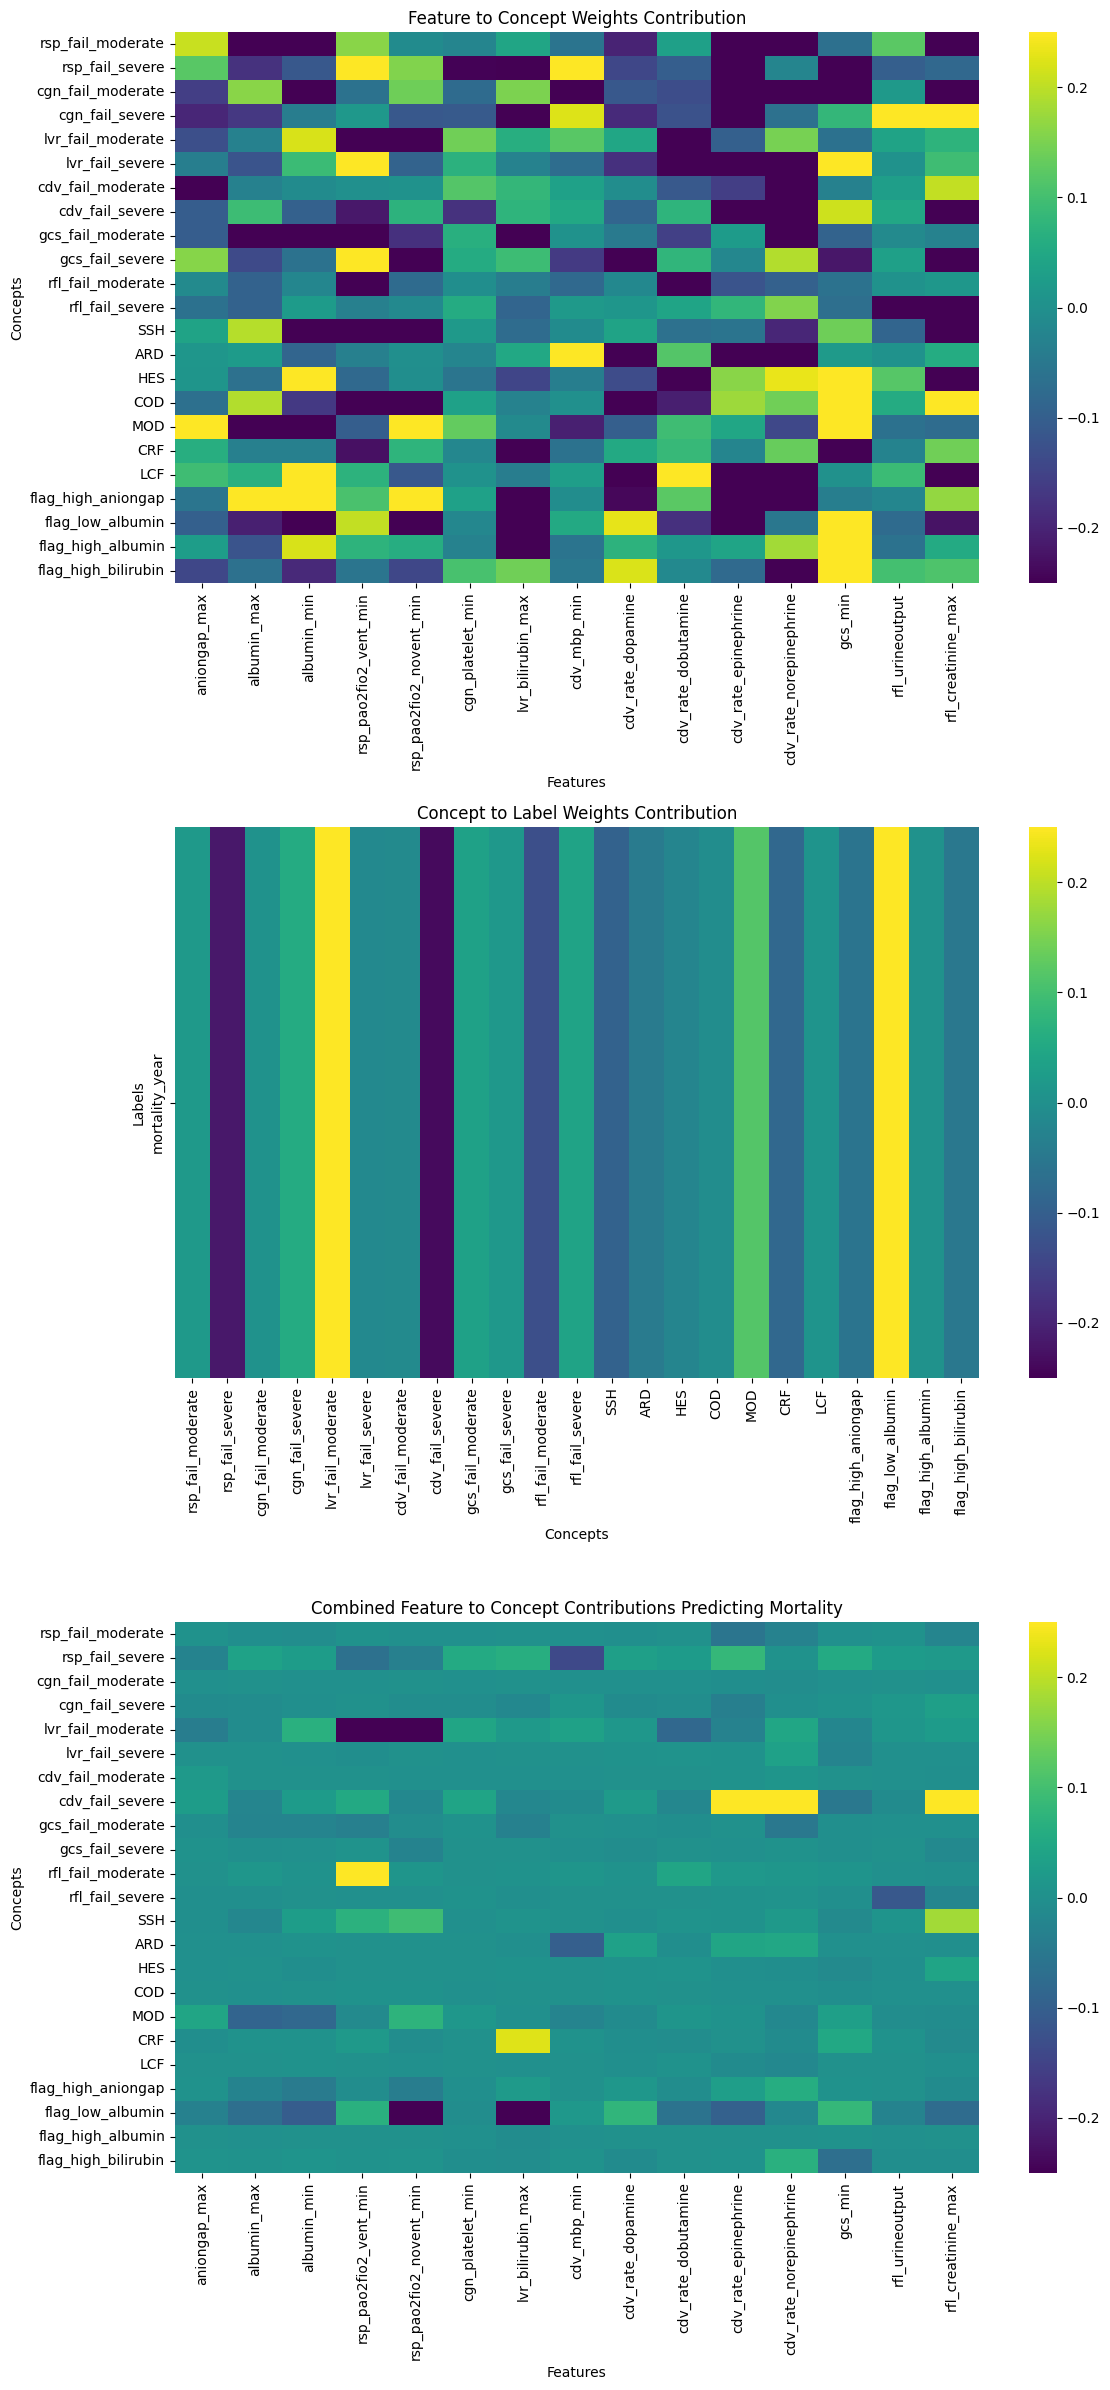

In [25]:
# Define the fixed scale for the heatmaps
fixed_vmin = -0.25  # Set your desired minimum value
fixed_vmax = 0.25  # Set your desired maximum value

# Create a figure with three subplots arranged in a column
fig, axes = plt.subplots(nrows=3, figsize=(12, 24))

# Plotting the feature to concept weight
sns.heatmap(feature_to_concept_contributions, cmap='viridis', cbar=True, vmin=fixed_vmin, vmax=fixed_vmax, ax=axes[0])
axes[0].set_title('Feature to Concept Weights Contribution')
axes[0].set_xlabel('Features')
axes[0].set_ylabel('Concepts')

# Plotting the concept to label weight
sns.heatmap(concept_to_label_contributions, cmap='viridis', cbar=True, vmin=fixed_vmin, vmax=fixed_vmax, ax=axes[1])
axes[1].set_title('Concept to Label Weights Contribution')
axes[1].set_xlabel('Concepts')
axes[1].set_ylabel('Labels')

# Plotting the combined heatmap
sns.heatmap(combined_df, cmap='viridis', cbar=True, fmt=".2f", vmin=fixed_vmin, vmax=fixed_vmax, ax=axes[2])
axes[2].set_title('Combined Feature to Concept Contributions Predicting Mortality')
axes[2].set_xlabel('Features')
axes[2].set_ylabel('Concepts')

# Adjust layout
plt.tight_layout()

# Save the figure as a single image
plt.savefig('combined_heatmaps.png')

# Show the figure
plt.show()